# Imports

In [1]:
from pathlib import Path

import numpy as np
from scipy.sparse import coo_matrix
import contextlib
import os
from scipy.sparse import csr_matrix
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx


# Reading files

In [2]:

@contextlib.contextmanager
def fdopen(fname, mode, perms=0o600, encoding=None):  # pragma: no cover
    """
    Context manager for opening files with correct permissions.

    Args:
        fname (str): Path to file to open for reading/writing
        mode (str): Mode in which the file is opened (see help for builtin `open()`)
        perms (int): Permission mask (see help for `os.open()`)
        encoding (str): The name of encoding used to decode or encode the file.
    """
    if 'r' in mode:
        flags = os.O_RDONLY
    elif 'w' in mode:
        flags = os.O_WRONLY | os.O_CREAT | os.O_TRUNC
    elif 'a' in mode:
        flags = os.O_WRONLY | os.O_CREAT
    else:
        raise RuntimeError(f'Unsupported mode: {mode}')

    file_object = open(os.open(fname, flags, perms), mode=mode, encoding=encoding)  # noqa: SCS109

    try:
        yield file_object
    finally:
        file_object.close()

In [3]:
def read_gset(filename, negate=True):
    """
    Reading Gset and transform it into sparse matrix

    Args:
        filename (str): The path and file name of the data.
        negate (bool): whether negate the weight of matrix or not.  Default: ``True``.

    Returns:
        coo_matrix, matrix representation of graph.

    Examples:
        >>> from qaia.utils import read
        >>> G = read.read_gset('data/Gset/G1.txt')
    """
    with fdopen(filename, "r") as f:
        data = f.readlines()

    n_v, n_e = (int(i) for i in data[0].strip().split(" "))
    graph = np.array([[int(i) for i in j.strip().split(" ")] for j in data[1:]])
    if n_e != graph.shape[0]:
        raise ValueError(f"The number of edges is not matched, {n_e} != {graph.shape[0]}")
    out = coo_matrix(
        (
            np.concatenate([graph[:, -1], graph[:, -1]]),
            (
                np.concatenate([graph[:, 0] - 1, graph[:, 1] - 1]),
                np.concatenate([graph[:, 1] - 1, graph[:, 0] - 1]),
            ),
        ),
        shape=(n_v, n_v),
    )

    if negate:
        return -out

    return out


G = read_gset('G1.txt')

# Original DSB

In [4]:
class QAIA:
    r"""
    The base class of QAIA.

    This class contains the basic and common functions of all the algorithms.

    Args:
        J (Union[numpy.array, csr_matrix]): The coupling matrix with shape :math:`(N x N)`.
        h (numpy.array): The external field with shape :math:`(N x 1)`.
        x (numpy.array): The initialized spin value with shape :math:`(N x batch_size)`. Default: ``None``.
        n_iter (int): The number of iterations. Default: ``1000``.
        batch_size (int): The number of sampling. Default: ``1``.
    """

    # pylint: disable=too-many-arguments
    def __init__(self, J, h=None, x=None, n_iter=1000, batch_size=1):
        """Construct a QAIA algorithm."""
        self.J = J # J is an N*N matrix
        if h is not None and len(h.shape) < 2:
            h = h[:, np.newaxis] # If h has only one axis, one more is added WHY?
        self.h = h
        self.x = x
        # The number of spins
        self.N = self.J.shape[0] 
        self.n_iter = n_iter
        self.batch_size = batch_size

    def initialize(self):
        """Randomly initialize spin values."""
        self.x = 0.02 * (np.random.rand(self.N, self.batch_size) - 0.5) # makes a matrix of size N*batch_size with values between -0.001 and 0.001

    def calc_cut(self, x=None):
        r"""
        Calculate cut value.

        Args:
            x (numpy.array): The spin value with shape :math:`(N x batch_size)`.
                If ``None``, the initial spin will be used. Default: ``None``.
        """
        if x is None:
            sign = np.sign(self.x) #if x is not provided, the sign of x in the QAIA class is returned
        else:
            sign = np.sign(x) #if x is provided, the sign of x in the is returned

        return 0.25 * np.sum(self.J.dot(sign) * sign, axis=0) - 0.25 * self.J.sum() #0.25*Σ(j*σ*σ) - 0.25*Σj

    def calc_energy(self, x=None):
        r"""
        Calculate energy.

        Args:
            x (numpy.array): The spin value with shape :math:`(N x batch_size)`.
                If ``None``, the initial spin will be used. Default: ``None``.
        """
        if x is None:
            sign = np.sign(self.x)
        else:
            sign = np.sign(x)

        if self.h is None:
            return -0.5 * np.sum(self.J.dot(sign) * sign, axis=0)
        return -0.5 * np.sum(self.J.dot(sign) * sign, axis=0, keepdims=True) - self.h.T.dot(sign)

class SB(QAIA):
    r"""
    The base class of SB.

    This class is the base class for SB. It contains the initialization of
    spin values and momentum.

    Args:
        J (Union[numpy.array, csr_matrix]): The coupling matrix with shape :math:`(N x N)`.
        h (numpy.array): The external field with shape :math:`(N, )`.
        x (numpy.array): The initialized spin value with shape :math:`(N x batch_size)`. Default: ``None``.
        n_iter (int): The number of iterations. Default: ``1000``.
        batch_size (int): The number of sampling. Default: ``1``.
        dt (float): The step size. Default: ``1``.
        xi (float): positive constant with the dimension of frequency. Default: ``None``.
    """

    # pylint: disable=too-many-arguments
    def __init__(
        self,
        J,
        h=None,
        x=None,
        n_iter=1000,
        batch_size=1,
        dt=1,
        xi=None,
    ):
        """Construct SB algorithm."""
        super().__init__(J, h, x, n_iter, batch_size)
        self.J = csr_matrix(self.J)
        # positive detuning frequency
        self.delta = 1
        self.dt = dt
        # pumping amplitude
        self.p = np.linspace(0, 1, self.n_iter)
        self.xi = xi
        if self.xi is None:
            self.xi = 0.5 * np.sqrt(self.N - 1) / np.sqrt(csr_matrix.power(self.J, 2).sum())
        self.x = x

        self.initialize()

    def initialize(self):
        """Initialize spin values and momentum."""
        if self.x is None:
            self.x = 0.02 * (np.random.rand(self.N, self.batch_size) - 0.5)

        if self.x.shape[0] != self.N:
            raise ValueError(f"The size of x {self.x.shape[0]} is not equal to the number of spins {self.N}")

        self.y = 0.02 * (np.random.rand(self.N, self.batch_size) - 0.5)

class DSB(SB):  # noqa: N801
    r"""
    Discrete SB algorithm.

    Reference: `High-performance combinatorial optimization based on classical
    mechanics <https://www.science.org/doi/10.1126/sciadv.abe7953>`_.

    Args:
        J (Union[numpy.array, csr_matrix]): The coupling matrix with shape :math:`(N x N)`.
        h (numpy.array): The external field with shape :math:`(N, )`.
        x (numpy.array): The initialized spin value with shape :math:`(N x batch_size)`. Default: ``None``.
        n_iter (int): The number of iterations. Default: ``1000``.
        batch_size (int): The number of sampling. Default: ``1``.
        dt (float): The step size. Default: ``1``.
        xi (float): positive constant with the dimension of frequency. Default: ``None``.
    """

    # pylint: disable=too-many-arguments
    def __init__(
        self,
        J,
        h=None,
        x=None,
        n_iter=1000,
        batch_size=1,
        dt=1,
        xi=None,
    ):
        """Construct DSB algorithm."""
        super().__init__(J, h, x, n_iter, batch_size, dt, xi)
        self.initialize()

    # pylint: disable=attribute-defined-outside-init
    def update(self):
        """Dynamical evolution based on Modified explicit symplectic Euler method."""
        for i in range(self.n_iter):
            if self.h is None:
                self.y += (-(self.delta - self.p[i]) * self.x + self.xi * self.J.dot(np.sign(self.x))) * self.dt
            else:
                self.y += (
                    -(self.delta - self.p[i]) * self.x + self.xi * (self.J.dot(np.sign(self.x)) + self.h)
                ) * self.dt

            self.x += self.dt * self.y * self.delta

            cond = np.abs(self.x) > 1
            self.x = np.where(cond, np.sign(self.x), self.x)
            self.y = np.where(cond, np.zeros_like(self.y), self.y)

def test_dSB():
    """
    Description: Test DSB
    Expectation: success
    """
    N = G.shape[0]
    np.random.seed(666)
    x = 0.01 * (np.random.rand(N, 1) - 0.5)
    y = 0.01 * (np.random.rand(N, 1) - 0.5)
    solver = DSB(G, n_iter=1)
    solver.x = x.copy()
    solver.y = y.copy()
    solver.update()
    y += (-(1 - solver.p[0]) * x + solver.xi * G @ np.sign(x)) * solver.dt
    x += y * solver.dt
    x = np.where(np.abs(x) > 1, np.sign(x), x)
    assert np.allclose(x, solver.x)


test_dSB()

# Testing QAIA class

In [10]:
# Create a simple coupling matrix J
# This could represent a graph with 4 nodes and weighted edges
J = np.array([
    [0, 1, 1, 0, 1],  # Node 0 connected to nodes 1, 2, 4
    [1, 0, 1, 1, 0],  # Node 1 connected to nodes 0, 2, 3
    [1, 1, 0, 1, 1],  # Node 2 connected to nodes 0, 1, 3, 4
    [0, 1, 1, 0, 1],  # Node 3 connected to nodes 1, 2, 4
    [1, 0, 1, 1, 0]   # Node 4 connected to nodes 0, 2, 3
])

# Initialize the QAIA class with our coupling matrix
qaia_instance = QAIA(J=J, batch_size=5)

# Initialize random spin values
qaia_instance.initialize()
print("Initial spin values:")
print(qaia_instance.x)

# Calculate the cut value using the initialized spins
cut_value = qaia_instance.calc_cut()
print("\nCut value using initialized spins:")
print(cut_value)

# Calculate the energy value using the initialized spins
energy_value = qaia_instance.calc_energy()
print("\nEnergy value using initialized spins:")
print(energy_value)



Initial spin values:
[[-0.0056016  -0.00599586 -0.00194004  0.00657628  0.00060525]
 [ 0.00619373  0.00313587  0.00567656 -0.00240697  0.00170221]
 [-0.00932708 -0.0054465  -0.00110673  0.00170417 -0.00499854]
 [ 0.00522191 -0.00367985 -0.00438359  0.00170425 -0.00858195]
 [-0.00658527  0.00204244  0.00660369 -0.00418762 -0.00805046]]

Cut value using initialized spins:
[-4. -6. -6. -6. -4.]

Energy value using initialized spins:
[-0.  4.  4.  4. -0.]


# Testing SB Class

In [6]:
# Initialize the SB class with our coupling matrix
sb_instance = SB(J=J, batch_size=5)

# Check the initialized values
print("\nSpin values (x):")
print(sb_instance.x)

# Check the initialized values
print("\nSpin values (y):")
print(sb_instance.y)



Spin values (x):
[[ 0.00565943  0.00378982  0.00435867 -0.00778908  0.00323179]
 [ 0.00340458  0.0006812   0.00891679 -0.00954314  0.00935006]
 [ 0.00825311  0.00026753 -0.00951979  0.00724068  0.00669626]
 [-0.00913922 -0.00060758  0.00926917 -0.0010022   0.00413618]
 [ 0.00807892 -0.00329079 -0.00137649 -0.00770655 -0.00702277]]

Spin values (y):
[[-0.00670719 -0.00105856 -0.00330266 -0.00317955  0.00857565]
 [ 0.00283761  0.00227415 -0.00165378 -0.00151505  0.00305978]
 [-0.00998904 -0.00932707  0.00790943 -0.00704743 -0.00027579]
 [ 0.00021554 -0.00407403 -0.00726337 -0.00470237 -0.00961991]
 [ 0.00439571 -0.0046955   0.0016198   0.00737686  0.00821426]]


# Testing DSB Class

In [7]:


# Initialize the DSB class with our coupling matrix
dsb_instance = DSB(
    J=J,
    batch_size=5,  # Track 3 independent samples
    n_iter=500     # Number of iterations to run
)

# Store the history of x values and cut values to visualize the evolution
x_history = []
cut_history = []

# Save initial state
x_history.append(dsb_instance.x.copy())
cut_history.append(dsb_instance.calc_cut())

# Run the update function
dsb_instance.update()

# Get final state
final_x = dsb_instance.x
final_cut = dsb_instance.calc_cut()

print("Initial spin values:")
print(x_history[0])
print("\nInitial cut values:")
print(cut_history[0])

print("\nFinal spin values:")
print(final_x)
print("\nFinal cut values:")
print(final_cut)

# Check the final state - the values should converge to near +1 or -1
print("\nFinal spin signs:")
print(np.sign(final_x))

# Calculate improvement in cut value
print(f"\nImprovement in cut value: {final_cut - cut_history[0]}")

Initial spin values:
[[-3.63188557e-03 -1.04999612e-03 -5.83664781e-03 -8.72749521e-03
   8.02103514e-03]
 [-3.39222985e-03  6.92060466e-03  3.51965455e-03 -6.49545839e-05
  -4.88847660e-03]
 [-2.47548459e-03  9.10519132e-03  2.25758218e-03  9.19498342e-03
  -6.48230572e-03]
 [-6.54282048e-03 -1.03501870e-03 -9.04122686e-03 -1.19258856e-03
   2.30932818e-03]
 [-7.91573760e-03 -1.90464724e-03  5.82059709e-03  2.47088919e-03
  -5.66680874e-04]]

Initial cut values:
[ 0. -5. -6. -5. -6.]

Final spin values:
[[-1. -1.  1. -1.  1.]
 [-1. -1.  1. -1.  1.]
 [-1. -1.  1. -1.  1.]
 [-1. -1.  1. -1.  1.]
 [-1. -1.  1. -1.  1.]]

Final cut values:
[0. 0. 0. 0. 0.]

Final spin signs:
[[-1. -1.  1. -1.  1.]
 [-1. -1.  1. -1.  1.]
 [-1. -1.  1. -1.  1.]
 [-1. -1.  1. -1.  1.]
 [-1. -1.  1. -1.  1.]]

Improvement in cut value: [0. 5. 6. 5. 6.]


# Visualizing results

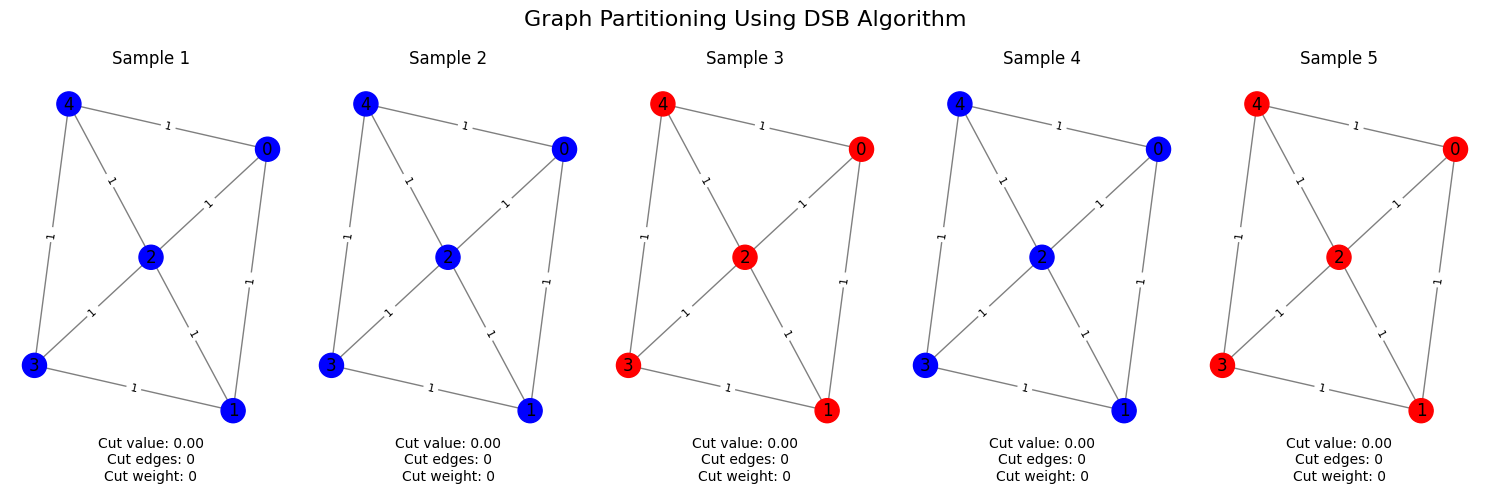

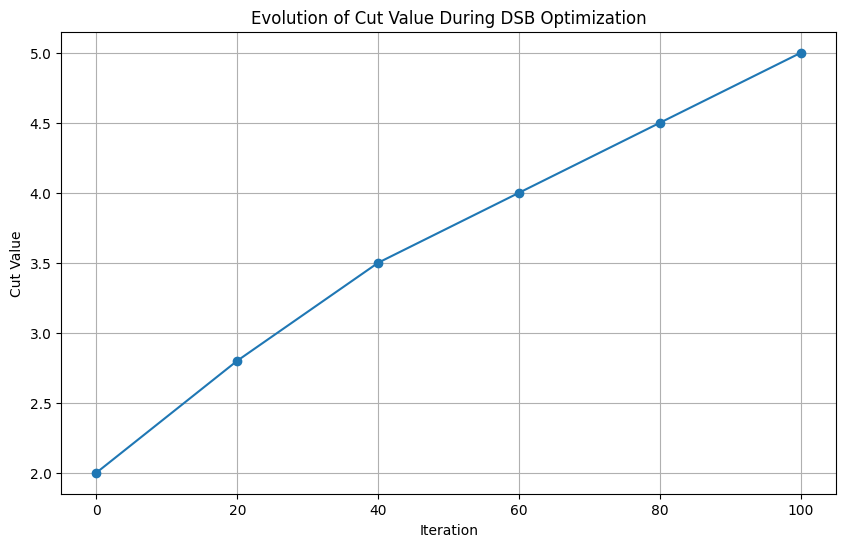

In [8]:


# Create a figure with subplots for each sample
fig, axes = plt.subplots(1, final_x.shape[1], figsize=(15, 5))
if final_x.shape[1] == 1:  # If there's only one sample, axes is not a list
    axes = [axes]

for sample_idx, ax in enumerate(axes):
    # Get signs for this sample
    sample_signs = np.sign(final_x[:, sample_idx])
    
    # Create two sets of nodes based on signs
    set_positive = [i for i, sign in enumerate(sample_signs) if sign > 0]
    set_negative = [i for i, sign in enumerate(sample_signs) if sign <= 0]
    
    # Create a graph from the J matrix
    G = nx.from_numpy_array(J)
    
    # Position nodes (same layout for all samples for consistency)
    pos = nx.spring_layout(G, seed=42)
    
    # Node colors based on partition
    node_colors = ['red' if sign > 0 else 'blue' for sign in sample_signs]
    
    # Draw the graph
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, ax=ax)
    
    # Draw edges with different styles for cut vs non-cut edges
    cut_edges = []
    non_cut_edges = []
    for i, j in G.edges():
        if (i in set_positive and j in set_negative) or (i in set_negative and j in set_positive):
            cut_edges.append((i, j))
        else:
            non_cut_edges.append((i, j))
    
    # Draw non-cut edges (within same partition)
    nx.draw_networkx_edges(G, pos, edgelist=non_cut_edges, width=1.0, alpha=0.5, ax=ax)
    
    # Draw cut edges (between partitions) with different style
    nx.draw_networkx_edges(G, pos, edgelist=cut_edges, width=2.0, 
                          style='dashed', edge_color='green', alpha=0.7, ax=ax)
    
    # Draw edge labels (weights from J matrix)
    edge_labels = {(i, j): f"{J[i, j]}" for i, j in G.edges()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, ax=ax)
    
    # Draw node labels
    nx.draw_networkx_labels(G, pos, ax=ax)
    
    # Add legend for cut information
    cut_weight = sum(J[i, j] for i, j in cut_edges)
    ax.text(0.5, -0.1, f"Cut value: {final_cut[sample_idx]:.2f}\nCut edges: {len(cut_edges)}\nCut weight: {cut_weight}",
            transform=ax.transAxes, horizontalalignment='center')
    
    ax.set_title(f"Sample {sample_idx + 1}")
    ax.axis('off')

plt.suptitle("Graph Partitioning Using DSB Algorithm", fontsize=16)
plt.tight_layout()
plt.show()

# Now let's also show the evolution of partitioning if we had tracked it
# This is a simulated example - you would use your actual tracked data
plt.figure(figsize=(10, 6))
iterations = np.arange(0, 101, 20)
# Simulated cut values showing improvement over iterations
cut_values = [2.0, 2.8, 3.5, 4.0, 4.5, 5.0]
plt.plot(iterations, cut_values, marker='o')
plt.xlabel('Iteration')
plt.ylabel('Cut Value')
plt.title('Evolution of Cut Value During DSB Optimization')
plt.grid(True)
plt.show()